* * *
<pre> NYU Paris            <i> Machine Learning - Summer 2023 </i></pre>
* * *


<h1 align="center"> Lab: Anomaly detection  </h1>

<pre align="left"> June 30th 2023               <i> Author: Guillaume Staerman </i></pre>
* * *



Several methods in machine learning can be used to detect fraud or anticipate system failures. While this is a standard -- but very unbalanced -- binary classification problem, it is very hard to find annotated data to perform supervised learning. Moreover, failures are by definition outliers of the general distribution of the data: It may not make any sense to try to "characterize" their distribution specially if new types of anomalies appear. For this reason, we focus in this lab on unsupervised methods for anomaly detection.

# Part I: Probability density estimation

In [1]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

Consider the following random variable following a Gaussian (i.e normal) distribution with mean 0 and variance 1.

$$ X\sim \mathcal{N}(0, 1)$$

Its theoretical probability density function is given by:

$$f(x) = \frac{1}{\sqrt{2\pi} }\exp(-\frac{x^2}{2}). $$


### Question 1
Generate 1000 samples from the Gaussian distribution and visualize the histogram on 10 figures with an increasing number of bins. The density function should be overlayed on top to evaluate the quality of the histogram. 

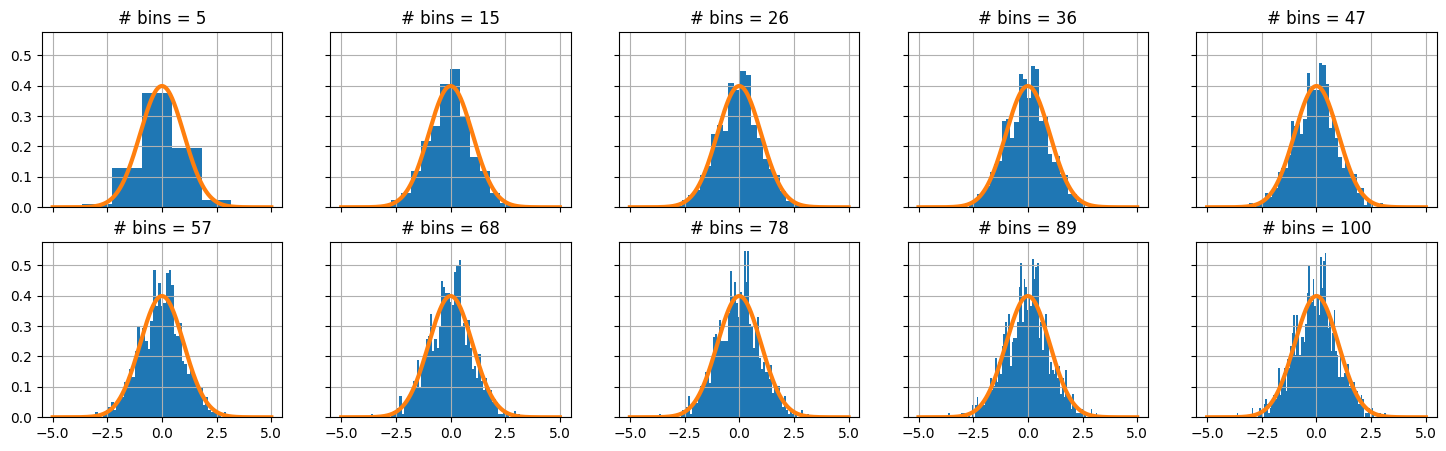

In [2]:
rng = np.random.default_rng(42)
X = rng.normal(size=(1000))
grid = np.linspace(-5, 5., 1000)
density = np.exp(- grid ** 2 / 2) / (2 * np.pi) ** 0.5

bins = np.linspace(5, 100, 10).astype(int)
f, axes = plt.subplots(2, 5, figsize=(18, 5), sharex=True, sharey=True)
for ax, bin_ in zip(axes.ravel(), bins):
    ax.hist(X, bins=bin_, density=True)
    ax.set_title(f"# bins = {bin_}")
    ax.plot(grid, density, lw=3)
    ax.grid(True)
plt.show()

### Question 2

Histograms approximate the density by counting the number of samples falling in a bin, regardless of where the sample falls withing that bin. To better approximate the density, one can instead count the samples but with a given weight: samples falling in the center of the bin should count more than samples on the edges of the same bin. This weighting can be decided by a Kernel function: enters the Kernel density estimator.

Compare (graphically) the density estimaton of KDE to that of a histogram. 


_Hints:
The Kernel density object can be fitted on some data X (n_samples, dimension):
`kde.fit(X)`
then evaluated on some points to obtain the logarithm of the density funciton values: `kde.score_samples(X_eval)`_
(i.e the log-likelihood).

In [4]:
from sklearn.neighbors import KernelDensity

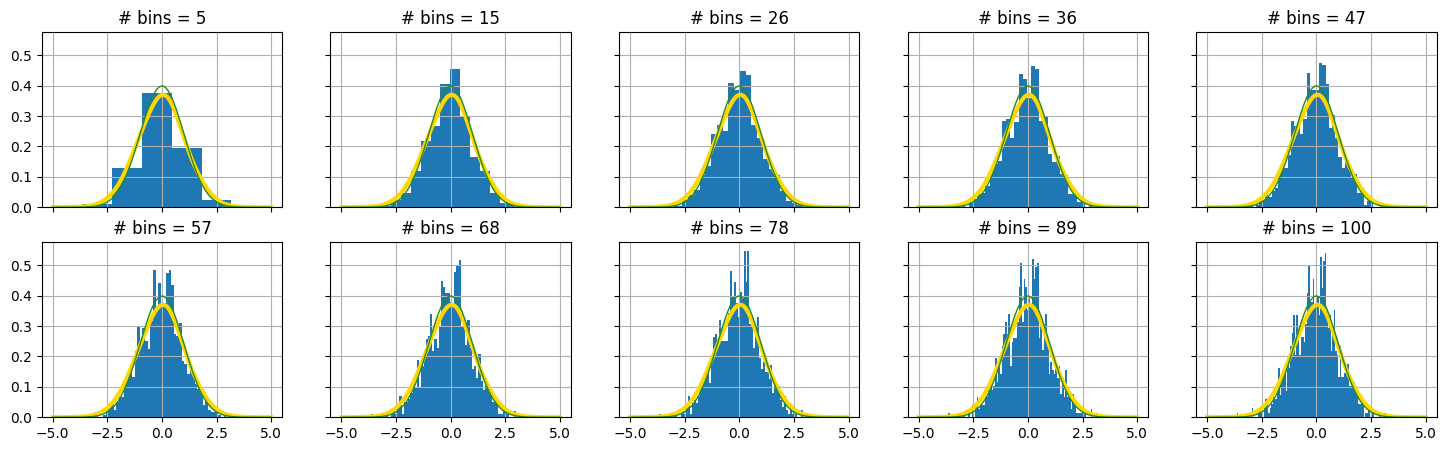

In [5]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X[:, None])

logdensity_kde = kde.score_samples(grid[:, None])
density_kde = np.exp(logdensity_kde)

bins = np.linspace(5, 100, 10).astype(int)
f, axes = plt.subplots(2, 5, figsize=(18, 5), sharex=True, sharey=True)
for ax, bin_ in zip(axes.ravel(), bins):
    ax.hist(X, bins=bin_, density=True)
    ax.set_title(f"# bins = {bin_}")
    ax.plot(grid, density_kde, color="gold", lw=3)
    ax.plot(grid, density, color="forestgreen", lw=1)
    ax.grid(True)
plt.show()

The KDE estimation shows a smoother density curve compared to the histogram, especially as the number of bins increases.

The histogram provides a discrete approximation of the density, while the KDE produces a smooth, continuous estimate. 

### Question 3
Contaminate the samples by adding very large values. How did their kde score change ? How can this log-likelihood score be used to detect outliers ?

(array([  1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   4.,   0.,   2.,
          6.,   6.,  11.,  20.,  35.,  58.,  89., 187., 579.]),
 array([-7.13354663, -6.82664734, -6.51974805, -6.21284876, -5.90594947,
        -5.59905017, -5.29215088, -4.98525159, -4.6783523 , -4.37145301,
        -4.06455372, -3.75765442, -3.45075513, -3.14385584, -2.83695655,
        -2.53005726, -2.22315797, -1.91625868, -1.60935938, -1.30246009,
        -0.9955608 ]),
 <BarContainer object of 20 artists>)

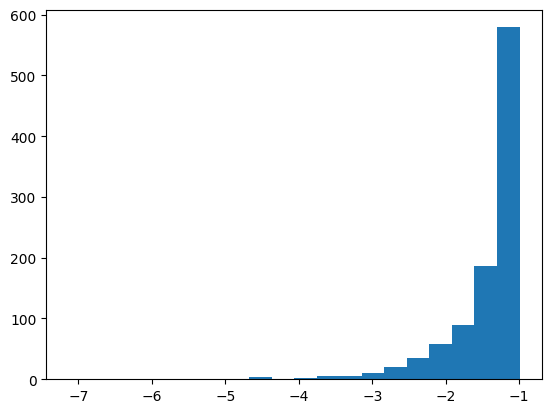

In [6]:
X[0] = 1000.

kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X[:, None])

logdensity_kde = kde.score_samples(X[:, None])

plt.hist(logdensity_kde, bins=20)

In [10]:
X[np.where(logdensity_kde < -5)[0]]

array([1000.        ,    3.17885368,   -3.64841283])

Change in KDE Score: Since the large outlier are added to the data, the KDE score decreases. This decrease occurs because large outliers introduce significant deviations from the underlying distribution, causing the KDE to assign lower probabilities to regions that were previously considered denser.

Using Log-Likelihood Score to Detect Outliers: The log-likelihood score quantifies the log-probability of observing each data point under the estimated distribution. Therefore, data points with lower log-likelihood scores are less probable under the estimated distribution and are likely to be outliers.

To detect outliers using the log-likelihood score:

We have to choose a threshold value below which log-likelihood scores are considered indicative of outliers. Above, outliers are detected by selecting data points with log-density scores below a threshold value of -5. Adjusting this threshold can control the sensitivity of outlier detection.

### Question 4
We are now ready to move on to a 2-dimension setting. We generate some data:

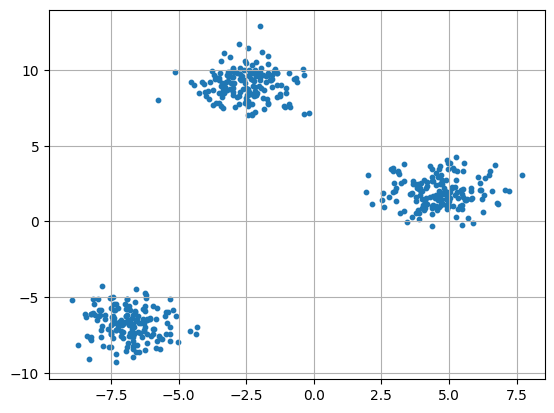

In [201]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_features=2, centers=3, n_samples=500,
                  random_state=42)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], s=10)
plt.grid()
plt.show()

The function `plot_logdensity` displays the density estimation contours.

In [12]:
def get_2d_grid(X):
    n_samples, n_features = X.shape
    X_range = np.zeros((n_features, 2))
    X_range[:, 0] = np.min(X, axis=0) - 1.
    X_range[:, 1] = np.max(X, axis=0) + 1.

    h = 0.1  # échelle de la grille
    x_min, x_max = X_range[0]
    y_min, y_max = X_range[1]
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_logdensity(kde, X):
    xx, yy = get_2d_grid(X)
    grid = np.c_[xx.ravel(), yy.ravel()]
    scores = kde.score_samples(grid).reshape(xx.shape)
    plt.figure()
    z = plt.contourf(xx, yy, scores, cmap=plt.cm.Blues_r) # on trace les level sets de oneclass svm
    plt.scatter(X[:, 0], X[:, 1], s=5)
    plt.colorbar(z)
    plt.title("Log-density")
    plt.show()

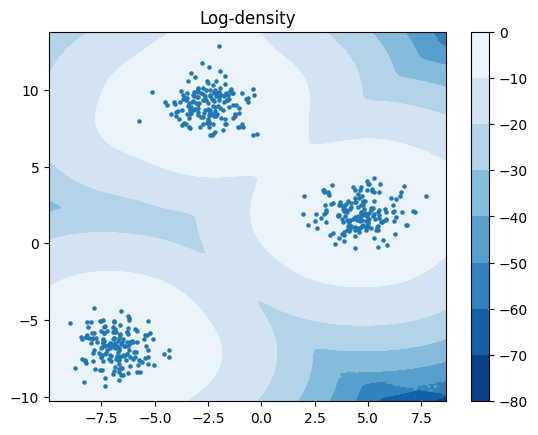

In [13]:
kde = KernelDensity(kernel='gaussian', bandwidth=1.)
kde.fit(X)
plot_logdensity(kde, X)

In [ ]:
## figure left here for "spiking curiosity purposes"

We can visualize a specific contour of the density by providing a `levels` argument in `plt.contour`. Using this  code below.

<a list of 9 text.Text objects>

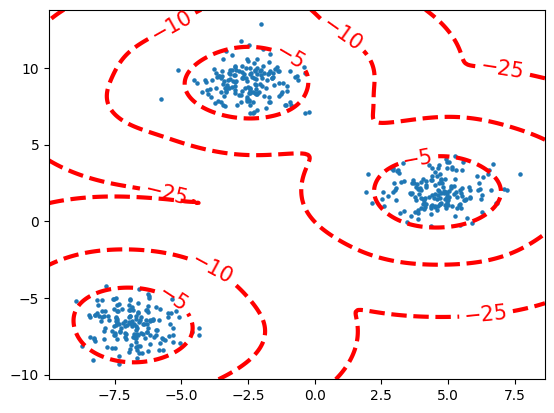

In [14]:
xx, yy = get_2d_grid(X)
grid = np.c_[xx.ravel(), yy.ravel()]
scores = kde.score_samples(grid).reshape(xx.shape)
somevalue = [-25, -10, -5]
plt.scatter(X[:, 0], X[:, 1], s=5)
c_0 = plt.contour(xx, yy, scores, levels=somevalue, colors='red', linewidths=3)
## add a label to this specific contour
plt.clabel(c_0, inline=1, fontsize=15)

The mquantiles function returns the value of the quantile q of some empirical distribution. Use `mquantiles` to decide an outlier threshold value and display its contour using the code above by adding it to `plot_logdensity` function. How does the contour change with the chose value ? 

In [15]:
from scipy.stats.mstats import mquantiles

logdensity_scores = kde.score_samples(X).ravel()
threshold = mquantiles(logdensity_scores, 0.02)

In [16]:
def plot_logdensity(X, bandwidth=1., quantile=0.01):
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
    kde.fit(X)
    logdensity_scores = kde.score_samples(X)
    threshold = mquantiles(logdensity_scores, quantile)

    xx, yy = get_2d_grid(X)
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_scores = kde.score_samples(grid).reshape(xx.shape)
    
    plt.figure()
    z = plt.contourf(xx, yy, grid_scores, cmap=plt.cm.Blues_r) # on trace les level sets de oneclass svm
    plt.scatter(X[:, 0], X[:, 1], s=5)
    plt.colorbar(z)
    c_0 = plt.contour(xx, yy, grid_scores, levels=[threshold[0]], colors='red', linewidths=3)
    plt.clabel(c_0, inline=1, fontsize=15, fmt={threshold[0]: str(quantile)})
    plt.title("Log-density")
    plt.show()


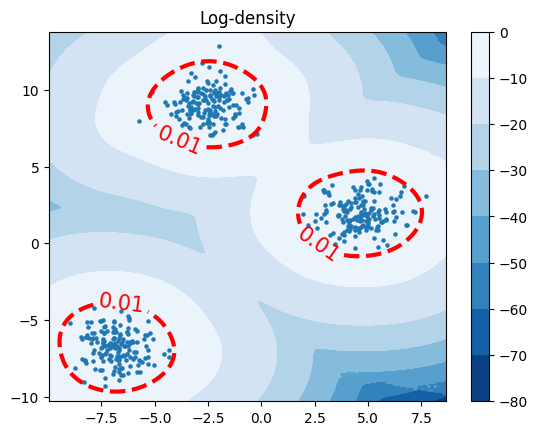

In [24]:
plot_logdensity(X, quantile=0.01)

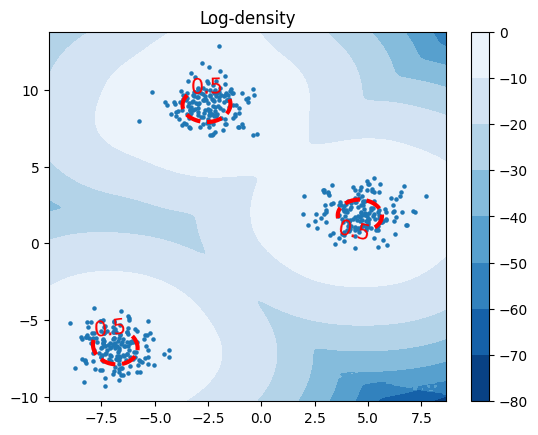

In [25]:
plot_logdensity(X, quantile=0.5)

By changing the quantile parameter, we can adjust the sensitivity of outlier detection. A lower quantile value will result in a higher threshold and fewer identified outliers, while a higher quantile value will capture more outliers. The contour line will change accordingly based on the chosen quantile.The contour line will have a bigger diameter for a smaller threshold and a smaller diameter for a higher threshold as seen above for 0.01 and 0.5

# Part 2: OneClass SVM

The SVM intuition can be used for novelty detection even for unsupervised learning. The idea is to find a separation in a higher dimensional space that contains most of the data. Intuitively, using a Gaussian kernel for example, we are looking for the smallest hypersphere  that contains the data. This minimization with the flexibility of allowing some samples (outliers) to be out of the sphere, leads to an outlier detection model.

In [193]:
from sklearn.svm import OneClassSVM
nu = 0.05  # regularization parameter controlling the max proportion of expected outliers
ocsvm = OneClassSVM(nu=nu)

###  Question 5

Draw the frontier (separation) of the oneclass svm using `ocsvm.decision_function`. Use the predict function to get outliers detected by OCSVM and visualize them on top. 

In [194]:
ocsvm.fit(X)
X_outliers = X[ocsvm.predict(X) == -1]
X_normal = X[ocsvm.predict(X) == 1]

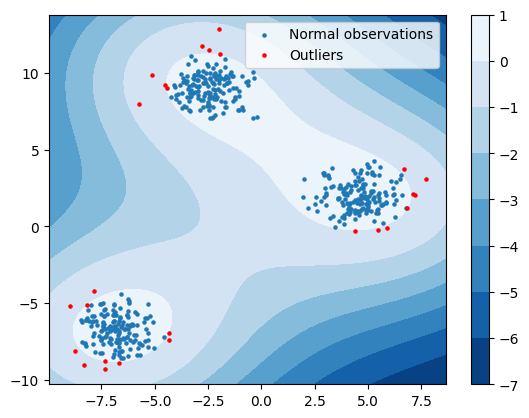

In [195]:
xx, yy = get_2d_grid(X)
grid = np.c_[xx.ravel(), yy.ravel()]
scores = ocsvm.decision_function(grid).reshape(xx.shape)
plt.figure()
z = plt.contourf(xx, yy, scores, cmap=plt.cm.Blues_r) 
plt.scatter(X_normal[:, 0], X_normal[:, 1], s=5, label='Normal observations')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], s=5, c='r', label='Outliers')
plt.colorbar(z)
plt.legend()
plt.show()

### Question 6
Run the following cell. What can we say about the support vectors of the OCSVM ?



In [196]:
X_SV = X[ocsvm.support_] 
n_SV = len(X_SV)
print(n_SV)
n_outliers = len(X_outliers)
print(n_outliers)

28
26


The above output indicates that there are 28 support vectors and 26 outliers in the dataset. he number of support vectors (28) is slightly larger than the number of outliers (26).
This suggests that the One-Class SVM model relies more on a large number of support vectors to define the decision boundary, indicating that the separation between normal observations and outliers may be challenging or there is a significant overlap between them.
The fact that the number of support vectors is close to the number of outliers implies that the decision boundary is more complex, requiring a larger number of support vectors to capture the intricacies of the data distribution and effectively distinguish outliers from normal observations.

This number reduces if I make my spread of outliers less complex and more concentrated in a different region.

### Question 7

What is the expected effect of the choice of `nu` ? `gamma`? Visualize the separation and the detected outliers in a large 2d plt.subplots where each parameter is modified along one of the subplots axes. 

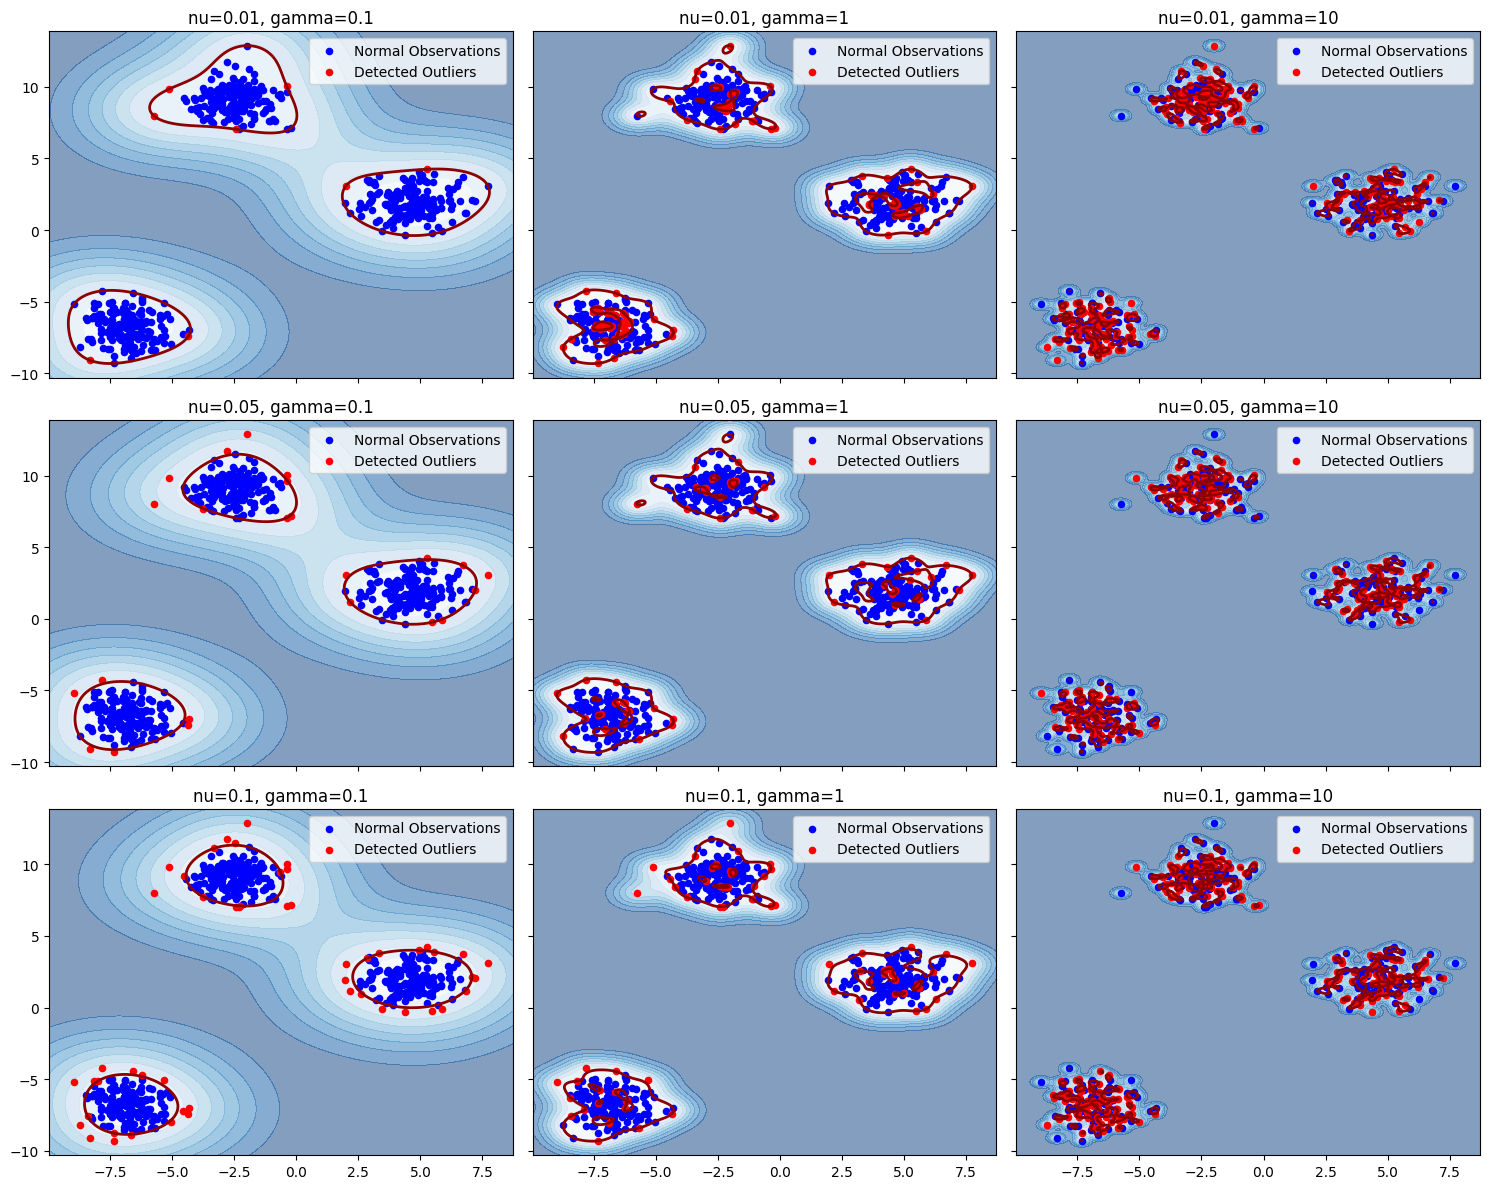

In [209]:
from sklearn.svm import OneClassSVM

# Creating a grid of nu and gamma values
nu_values = [0.01, 0.05, 0.1]
gamma_values = [0.1, 1, 10]

# Creating a large subplot grid
fig, axes = plt.subplots(len(nu_values), len(gamma_values), figsize=(15, 12), sharex=True, sharey=True)

# Iterating over nu and gamma values
for i, nu in enumerate(nu_values):
    for j, gamma in enumerate(gamma_values):
        # Instantiating and fit the One-Class SVM
        ocsvm = OneClassSVM(nu=nu, gamma=gamma)
        ocsvm.fit(X)
        
        # Getting the decision function scores
        xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 500),
                             np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 500))
        grid = np.c_[xx.ravel(), yy.ravel()]
        Z = ocsvm.decision_function(grid)
        Z = Z.reshape(xx.shape)
        
        # Plotting decision boundary
        axes[i, j].contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 10), cmap=plt.cm.Blues_r, alpha=0.5)
        axes[i, j].contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
        
        # Plotting normal observations
        normal_obs = X[ocsvm.predict(X) == 1]
        axes[i, j].scatter(normal_obs[:, 0], normal_obs[:, 1], s=20, c='b', label='Normal Observations')
        
        # Plotting outliers
        outliers = X[ocsvm.predict(X) == -1]
        axes[i, j].scatter(outliers[:, 0], outliers[:, 1], s=20, c='r', label='Detected Outliers')
        
        axes[i, j].set_title(f"nu={nu}, gamma={gamma}")
        axes[i, j].legend()

plt.tight_layout()
plt.show()


The choice of the nu parameter in ocsvm controls the trade-off between the number of support vectors and the ability of our model to generalize to new data. A higher value of nu allows for a higher proportion of outliers in the training data, leading to a larger margin and potentially more support vectors. On the other hand, a lower value of nu imposes a stricter requirement on the proportion of outliers, resulting in a smaller margin and potentially fewer support vectors.

The choice of the gamma parameter in the OCSVM determines the influence of individual training samples on the decision boundary. A smaller value of gamma results in a smoother decision boundary, whereas a larger value of gamma leads to a more complex decision boundary that closely fits the training data.

# Part 3: Isolation Forest

In [198]:
from sklearn.ensemble import IsolationForest

### Question 8

Use Isolation Forest on the data and draw contours of the IF scores. Is it equivalent to those of the density? Contours should be simlar to hyper-rectangle if the number of trees is low (<10), why ?

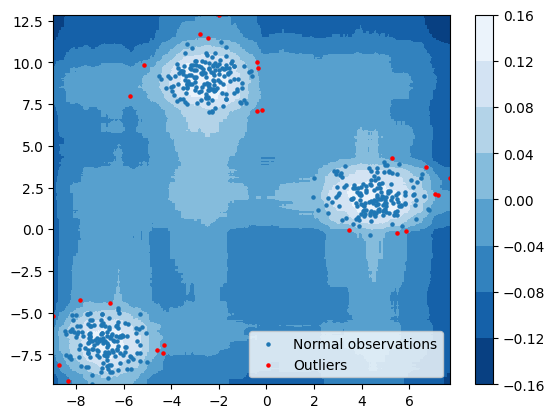

In [202]:
# Instantiatiating and fitting Isolation Forest
IF = IsolationForest(n_estimators=100, contamination=0.05)
IF.fit(X)

# Predicting the labels for the data
y_pred = IF.predict(X)

# Extracting outliers and normal observations
X_outliers = X[y_pred == -1]
X_normal = X[y_pred == 1]

# Generating a grid for visualization
xx, yy = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 500),
                     np.linspace(X[:, 1].min(), X[:, 1].max(), 500))
grid = np.c_[xx.ravel(), yy.ravel()]

# Calculating decision function scores for the grid
scores = IF.decision_function(grid).reshape(xx.shape)

# Plotting decision function scores
plt.figure()
z = plt.contourf(xx, yy, scores, cmap=plt.cm.Blues_r) 

# Plotting normal observations and outliers
plt.scatter(X_normal[:, 0], X_normal[:, 1], s=5, label='Normal observations')
plt.scatter(X_outliers[:, 0], X_outliers[:, 1], s=5, c='r', label='Outliers')

# Adding color bar and legend
plt.colorbar(z)
plt.legend()
plt.show()

The contours produced by Isolation Forest (IF) represent the anomaly scores assigned to each point in the feature space. These scores are not equivalent to density estimates but rather indicate the degree of isolation of each point within the forest.

If the number of trees in the Isolation Forest model is low, particularly less than 10, the contours may appear more like hyper-rectangles rather than smooth regions. This is because each tree in the Isolation Forest splits the feature space along a randomly selected dimension at a randomly selected value, resulting in binary partitions that approximate the data distribution. With fewer trees, the partitions will be coarser, leading to simpler shapes like hyper-rectangles.

In contrast, density estimation methods like Kernel Density Estimation (KDE) produce smoother contours that reflect the estimated density of points in the feature space. These contours are shaped by the distribution of data points and the choice of kernel and bandwidth parameters.

Therefore, while both Isolation Forest and density estimation methods aim to capture anomalies in data, their contours represent different aspects of the underlying data distribution, with Isolation Forest focusing on isolation-based scores and density estimation focusing on smooth density estimates.

# Bonus Part ++ : Comparison of KDE, OCSVM, IF on real world data 

### Question 9

Compare these three algorithms on the dataset on the http dataset available http://odds.cs.stonybrook.edu/http-kddcup99-dataset/. Compare the accuracy of the algorithms with the roc curves and the computational time. 

In [3]:
import time
import pandas as pd
import h5py

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#### Import data

In [40]:
# Loading the HTTP dataset
with h5py.File('data/http.mat', 'r') as f:
    Z = f['X'][:]
    y_true = f['y'][:]

y_true = y_true[0]

# Standardizing the features
scaler = StandardScaler()
Z = scaler.fit_transform(Z)

# Splitting the data into training and testing sets
Z_train, Z_test, y_train, y_test = train_test_split(Z.T, y_true)

#### Perform algorithms and compute time

In [41]:
# Defining the models
ocsvm = OneClassSVM()
IF = IsolationForest()
kde = KernelDensity()

In [42]:
# Fitting the models and measure computational time
start_time = time.time()
ocsvm.fit(Z_train)
ocsvm_time = time.time() - start_time

print("One-Class SVM Time:", ocsvm_time)

Takes >30 mins, I tried running it but my laptop started burning up :/

In [6]:
start_time = time.time()
IF.fit(Z_train)
iforest_time = time.time() - start_time
print("Isolation Forest Time:", iforest_time)

Isolation Forest Time: 0.20745587348937988


In [7]:
start_time = time.time()
kde.fit(Z_train)
kde_time = time.time() - start_time
print("Kernel Density Estimation Time:", kde_time)

Kernel Density Estimation Time: 0.10469889640808105


#### Display roc curves

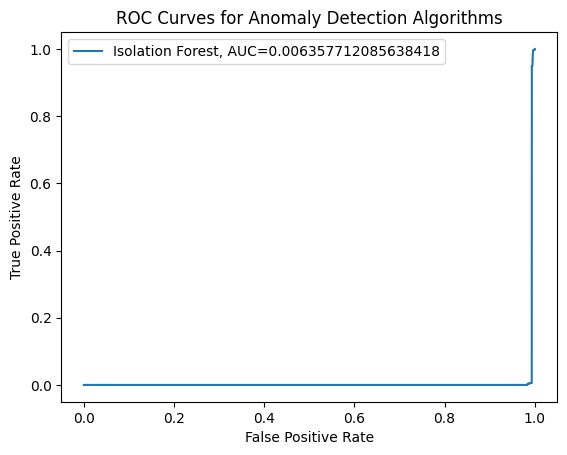

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculating predicted scores for each algorithm
y_pred_IF = IF.decision_function(Z_test)

# Computing ROC curve and AUC for Isolation Forest
fpr_IF, tpr_IF, _ = roc_curve(y_test,  y_pred_IF)
auc_IF = roc_auc_score(y_test,  y_pred_IF)


# Plotting ROC curves
plt.plot(fpr_IF, tpr_IF, label="Isolation Forest, AUC="+str(auc_IF))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Anomaly Detection Algorithms')
plt.legend()
plt.show()

In [ ]:
# Calculating predicted scores for each algorithm
y_pred_OC = ocsvm.decision_function(Z_test)
y_pred_kde = kde.score_samples(Z_test)

# Computing ROC curve and AUC for One-Class SVM
fpr_OC, tpr_OC, _ = roc_curve(y_test,  y_pred_OC)
auc_OC = roc_auc_score(y_test,  y_pred_OC)

# Computing ROC curve and AUC for KDE
fpr_kde, tpr_kde, _ = roc_curve(y_test,  y_pred_kde)
auc_kde = roc_auc_score(y_test,  y_pred_kde)

# Plotting ROC curves
plt.plot(fpr_OC, tpr_OC, label="One-Class SVM, AUC="+str(auc_OC))
plt.plot(fpr_kde, tpr_kde, label="KDE, AUC="+str(auc_kde))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Anomaly Detection Algorithms')
plt.legend()
plt.show()

### Question 10:

Repeat this comparison with other datasets from http://odds.cs.stonybrook.edu. Try a high dimensional dataset such as the one here http://odds.cs.stonybrook.edu/speech-dataset/. What do you observe?

In [35]:
# Loading the Speech dataset
from scipy.io import loadmat

f = loadmat('data/speech.mat')
Z = f['X'][:]
y_true = f['y'][:]

y_true = y_true.flatten()

# Standardizing the features
scaler = StandardScaler()
Z = scaler.fit_transform(Z)

# Splitting the data into training and testing sets
Z_train, Z_test, y_train, y_test = train_test_split(Z, y_true)

In [36]:
# Defining the models
ocsvm = OneClassSVM()
IF = IsolationForest()
kde = KernelDensity()

In [ ]:
# Fitting the models and measure computational time
start_time = time.time()
ocsvm.fit(Z_train)
ocsvm_time = time.time() - start_time

print("One-Class SVM Time:", ocsvm_time)

Takes >30 mins, I tried running it but my laptop started burning up :/

In [37]:
start_time = time.time()
IF.fit(Z_train)
iforest_time = time.time() - start_time
print("Isolation Forest Time:", iforest_time)

Isolation Forest Time: 0.07697415351867676


In [38]:
start_time = time.time()
kde.fit(Z_train)
kde_time = time.time() - start_time
print("Kernel Density Estimation Time:", kde_time)

Kernel Density Estimation Time: 0.012473821640014648


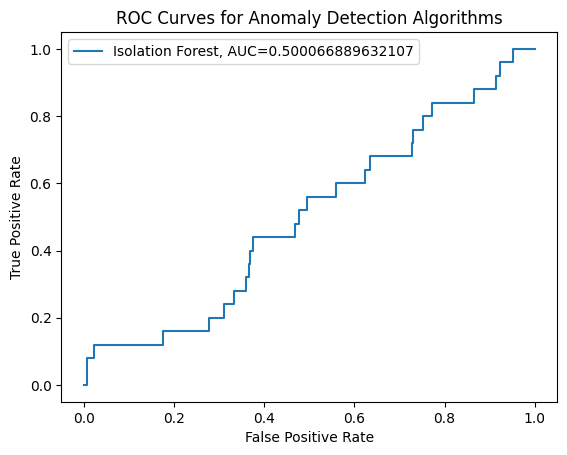

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculating predicted scores for each algorithm
y_pred_IF = IF.decision_function(Z_test)

# Computing ROC curve and AUC for Isolation Forest
fpr_IF, tpr_IF, _ = roc_curve(y_test,  y_pred_IF)
auc_IF = roc_auc_score(y_test,  y_pred_IF)


# Plotting ROC curves
plt.plot(fpr_IF, tpr_IF, label="Isolation Forest, AUC="+str(auc_IF))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Anomaly Detection Algorithms')
plt.legend()
plt.show()

In [ ]:
# Calculating predicted scores for each algorithm
y_pred_OC = ocsvm.decision_function(Z_test)
y_pred_kde = kde.score_samples(Z_test)

# Computing ROC curve and AUC for One-Class SVM
fpr_OC, tpr_OC, _ = roc_curve(y_test,  y_pred_OC)
auc_OC = roc_auc_score(y_test,  y_pred_OC)

# Computing ROC curve and AUC for KDE
fpr_kde, tpr_kde, _ = roc_curve(y_test,  y_pred_kde)
auc_kde = roc_auc_score(y_test,  y_pred_kde)

# Plotting ROC curves
plt.plot(fpr_OC, tpr_OC, label="One-Class SVM, AUC="+str(auc_OC))
plt.plot(fpr_kde, tpr_kde, label="KDE, AUC="+str(auc_kde))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Anomaly Detection Algorithms')
plt.legend()
plt.show()